In [4]:
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import keras

random.seed(30)
df = pd.read_csv("data/us_change.csv", index_col=0)
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [5]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers, regularizers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


sequence_length = 4  # Número de trimestres na janela de tempo
test_size = 0.2
val_size = 0.2


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Income', 'Production', 'Savings', 'Unemployment', 'Consumption']])

def create_sequences(data, target_idx, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, target_idx])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, target_idx=-1, seq_length=sequence_length)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)

inputs = layers.Input(shape=(sequence_length, X.shape[2]))

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)  

outputs = layers.Dense(1, kernel_regularizer=regularizers.l2(0.001))(x)
model = models.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 4, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 4, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 4, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 2, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 2, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 2, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 2, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 137 (548.00 B)

 Non-trainable params: 24 (96.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.8480 - mae: 0.7923 - val_loss: 0.3760 - val_mae: 0.5860
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8073 - mae: 0.7680 - val_loss: 0.3697 - val_mae: 0.5810
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7638 - mae: 0.7435 - val_loss: 0.3614 - val_mae: 0.5741
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7094 - mae: 0.7201 - val_loss: 0.3516 - val_mae: 0.5659
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6515 - mae: 0.7108 - val_loss: 0.3454 - val_mae: 0.5606
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6748 - mae: 0.7121 - val_loss: 0.3362 - val_mae: 0.5525
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6321 - mae: 0.6622 - val_loss: 0.3262 - val_mae: 0.5437
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5523 - mae: 0.6316 - val_loss: 0.3162 - val_mae: 0.5345
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5097 - mae: 0.6140 - val_loss

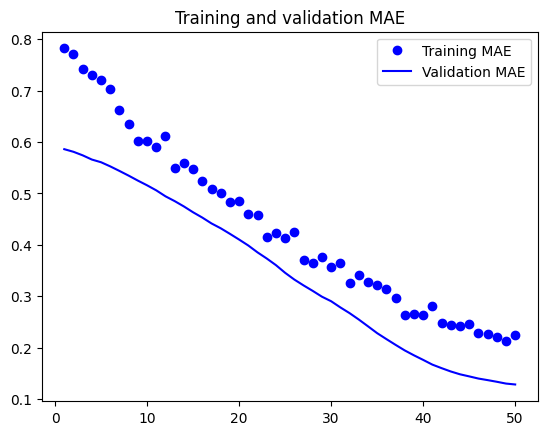

In [14]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()